# Earlier analysis showed mutiple components that have correlation with each other but not with the big dataset. This notebook wil investigated them further

### Load packages

In [1]:
from HelperClasses.LoadData import LoadCancer 
from HelperClasses.Correlation import Correlation 

import pandas as pd
import numpy as np
import os


import dcor
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy import stats


import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.palettes import Blues256

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Load the results of biological interpertation and get only the higest scores. This analysis checked for two components in seperate runs that didn't appear in big

In [2]:
b_int = pd.read_csv('/home/MarkF/DivideConquer/ICA/Results/Cancer_type/Biological_int.csv', index_col=0)
b_int = b_int[b_int['Score'] > 0.504]
b_int_components = list(set(b_int[['Small Component', 'Small2 Component']].values.ravel()))
b_int

Small Component  \
86         consensus independent component 105_Lymphoma   
507    consensus independent component 133_Brain cancer   
2555             consensus independent component 54_HCC   
1994  consensus independent component 35_Myelodyspla...   
2172  consensus independent component 41_Gastric cancer   
2922         consensus independent component 6_Melanoma   
2072           consensus independent component 38_HNSCC   
3384         consensus independent component 93_Sarcoma   
2537  consensus independent component 53_Prostate ca...   

                                 Big Component  \
86    consensus independent component 1655_big   
507   consensus independent component 1235_big   
2555  consensus independent component 2439_big   
1994  consensus independent component 2439_big   
2172  consensus independent component 1655_big   
2922  consensus independent component 1655_big   
2072  consensus independent component 2439_big   
3384   consensus independent component 855_big   
2537   consensus independent component 855_big   

                                       Small2 Component  \
86    consensus independent component 77_Multiple my...   
507        consensus independent component 105_Lymphoma   
2555     consensus independent component 7_Renal cancer   
1994       consensus independent component 105_Lymphoma   
2172     consensus independent component 7_Renal cancer   
2922       consensus independent component 105_Lymphoma   
2072       consensus independent component 105_Lymphoma   
3384     consensus independent component 7_Renal cancer   
2537     consensus independent component 7_Renal cancer   

                                Big2 Component     Score  
86     consensus independent component 885_big  0.578689  
507   consensus independent component 1655_big  0.571041  
2555  consensus independent component 3726_big  0.570593  
1994  consensus independent component 1655_big  0.567261  
2172  consensus independent component 3726_big  0.563479  
2922  consensus independent component 1655_big  0.560476  
2072  consensus independent component 1655_big  0.546864  
3384  consensus independent component 3726_big  0.529575  
2537  consensus independent component 3726_big  0.518656

Look if this is one cluster of components that all have the same funtion. (So if there is correlation between all of them). 

In [3]:
# Load the cancer data
datasets = LoadCancer('/home/MarkF/DivideConquer/Results/GPL570',
    '/home/MarkF/DivideConquer/Results/GPL570/All_Cancer/ICARUN/ica_independent_components_consensus.tsv')

Number of components split Lung cancer: 193
Number of components split Gastric cancer: 195
Number of components split Breast cancer: 339
Number of components split Sarcoma: 325
Number of components split Colorectal cancer: 190
Number of components split Prostate cancer: 106
Number of components split Renal cancer: 138
Number of components split HCC: 190
Number of components split Ovarian cancer: 158
Number of components split Lymphoma: 167
Number of components split Multiple myeloma: 89
Number of components split Normal: 605
Number of components split Leukemia: 102
Number of components split Adrenal cancer: 113
Number of components split Myelodysplastic syndrome: 84
Number of components split Brain cancer: 156
Number of components split Melanoma: 194
Number of components split HNSCC: 155
Number of components All data: 3776


### Check correlations

In [4]:
# Calculate the correlations
correlation = Correlation(datasets.get_merged_small(), 
                         datasets.get_sample_data())

In [5]:
# Function to put the correlation in the plot
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'{r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

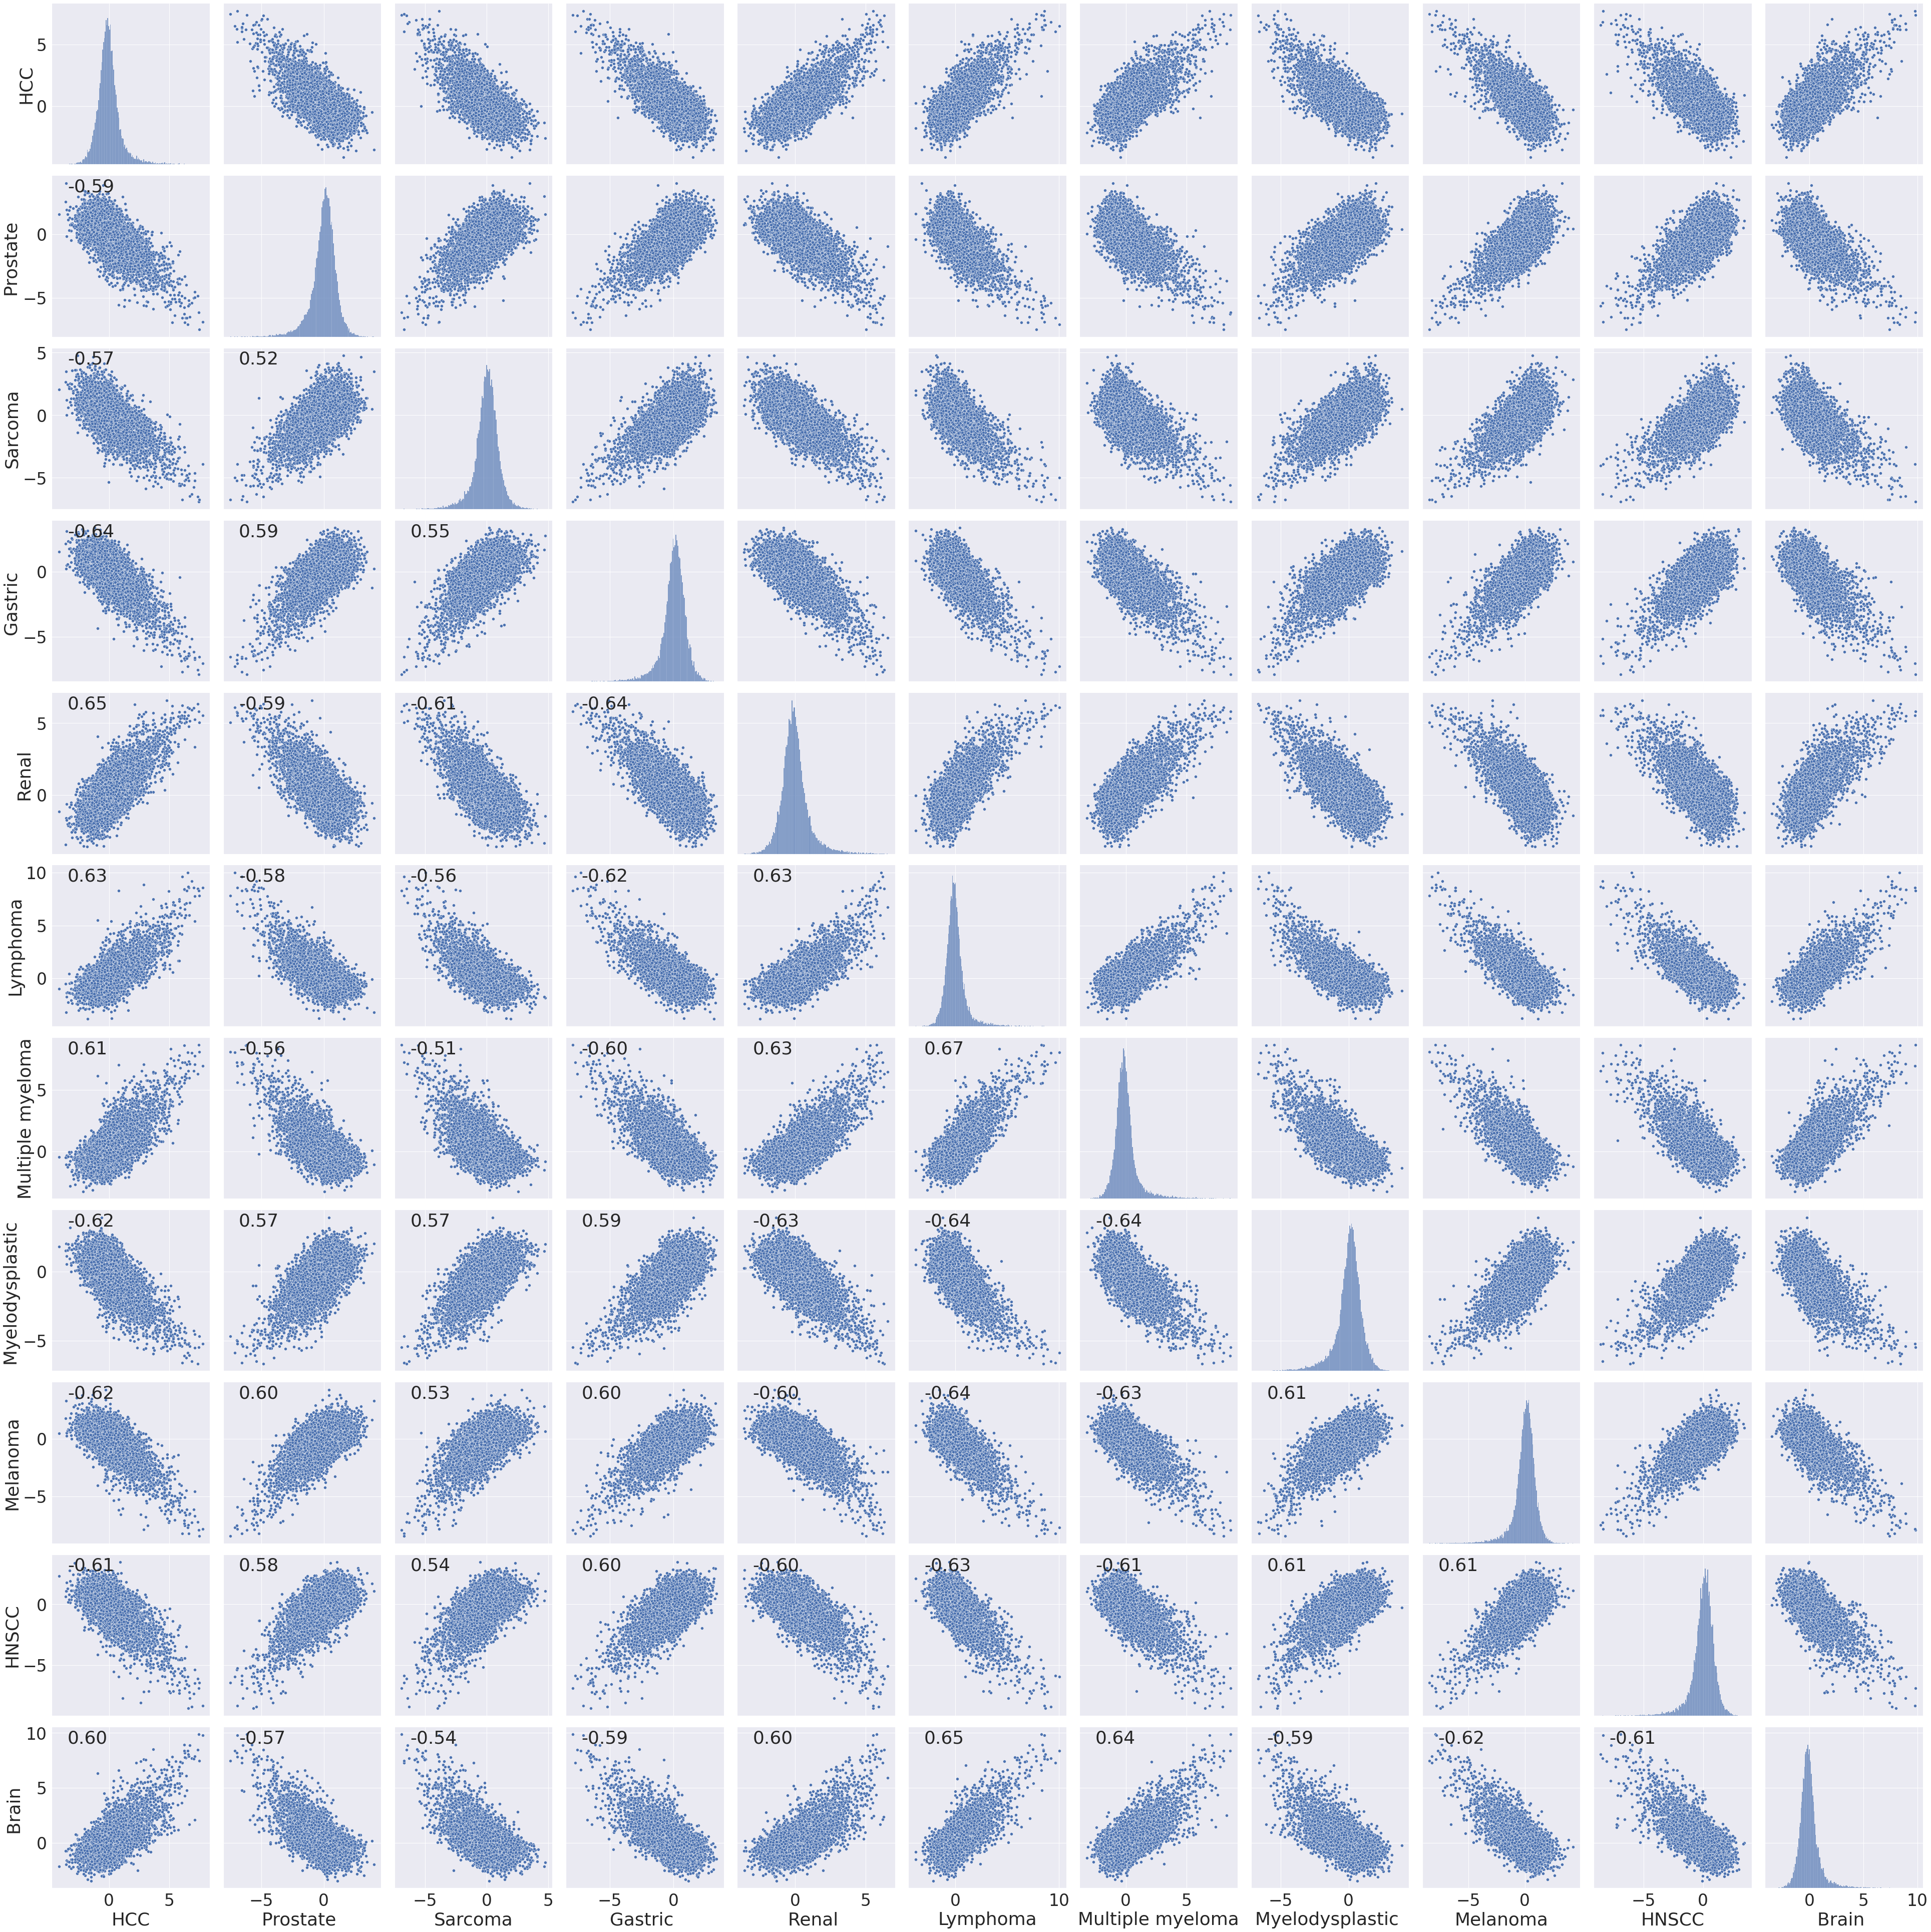

In [6]:
# Only get the component that are interesting in this analysis
cluster_df = datasets.get_all()[b_int_components]
# Plot it
cluster_df.columns = [x.split('_', 1)[-1].replace('cancer','').replace('syndrome','') for x in cluster_df.columns]
sns.set(font_scale=3)
g = sns.pairplot(cluster_df, corner=False, height=5)
g.map_lower(corrfunc)
plt.show()

### Maximun correlation of all these components with the sample dataset

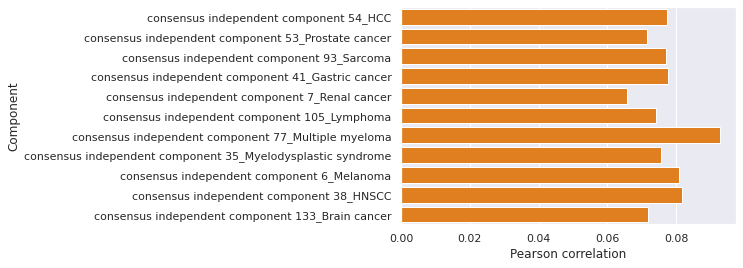

In [7]:
sns.set(font_scale=1)
plot_df = correlation.get_half_correlation().max(axis=0)[b_int_components].reset_index()
plot_df.columns = ['Component', 'Pearson correlation']
g = sns.barplot(data=plot_df, x='Pearson correlation', y='Component', color='#FF7F00')
plt.show()

There is a clear correlation between all these components in the small dataset. However, none of them have any correlation with the sample dataset. Implicating that this is a component that mutliple small runs found however it was missed in the sample run

### Does the size of the original dataset make the difference?

In [8]:
# Make subset of columns that appear and dont appear
all_groups = set([x.split('_')[1] for x in datasets.get_all().columns])
appearing = set([x.split('_')[1] for x in b_int_components])
not_appearing = all_groups.difference(appearing)
counts = [[],[]]
for var in not_appearing:
    if var != 'big':
        counts[0].append(datasets.get_individual_small()[var].shape[1])

for var in appearing:
    if var != 'big':
        counts[1].append(datasets.get_individual_small()[var].shape[1])
stats.ttest_ind(counts[0], counts[1], equal_var=False)

Ttest_indResult(statistic=1.1307394533089175, pvalue=0.29493997766571123)

No evidence that the amount of components made the difference.

## Do the new component have the same biological interpertation


In [9]:
# Load GSEA data
paths = [('GOBP', 'enrichment_matrix_Gene Ontology - Biolocal Processes.tsv'),
         ('HALLMARK', 'enrichment_matrix_Hallmark.tsv'),
         ('REACTOME','enrichment_matrix_Reactome.tsv')]
GSEA_ALL = {}
clean_cluster = []
mm = {}
# Loop over every set
for path in paths:
    first_run = True
    # Loop over new group
    for component in b_int_components:
        # Get the group
        cancer_group = component.split('_',1)[-1].replace(' ', '_')
        # Load the GSEA of this group
        df = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/{cancer_group}/GSEA/{path[1]}',
                         sep='\t', index_col=0)
        # Clean it and take the absolute
        df.columns = [f"{x}_{cancer_group.replace('_', ' ')}" for x in df.columns]
        df = df[component].abs()
        clean_cluster.append(component)
        # Save it in one big dataframe
        if first_run:
            GSEA = pd.DataFrame(df)
            first_run = False
        else:
            GSEA = GSEA.join(df)
        # Load mixing matrix  
        mm[cancer_group] = pd.read_csv(f'/home/MarkF/DivideConquer/Results/GPL570/{cancer_group}/ICARUN/ica_mixing_matrix_consensus.tsv', 
                         sep='\t', index_col=0)[component.split('_')[0]]
    GSEA.index = [x.split(' -- ')[0].replace(f'{path[0]}_','') for x in GSEA.index]
    GSEA_ALL[path[0]] = GSEA
clean_cluster = list(set(clean_cluster))

### Hallmark geneset  

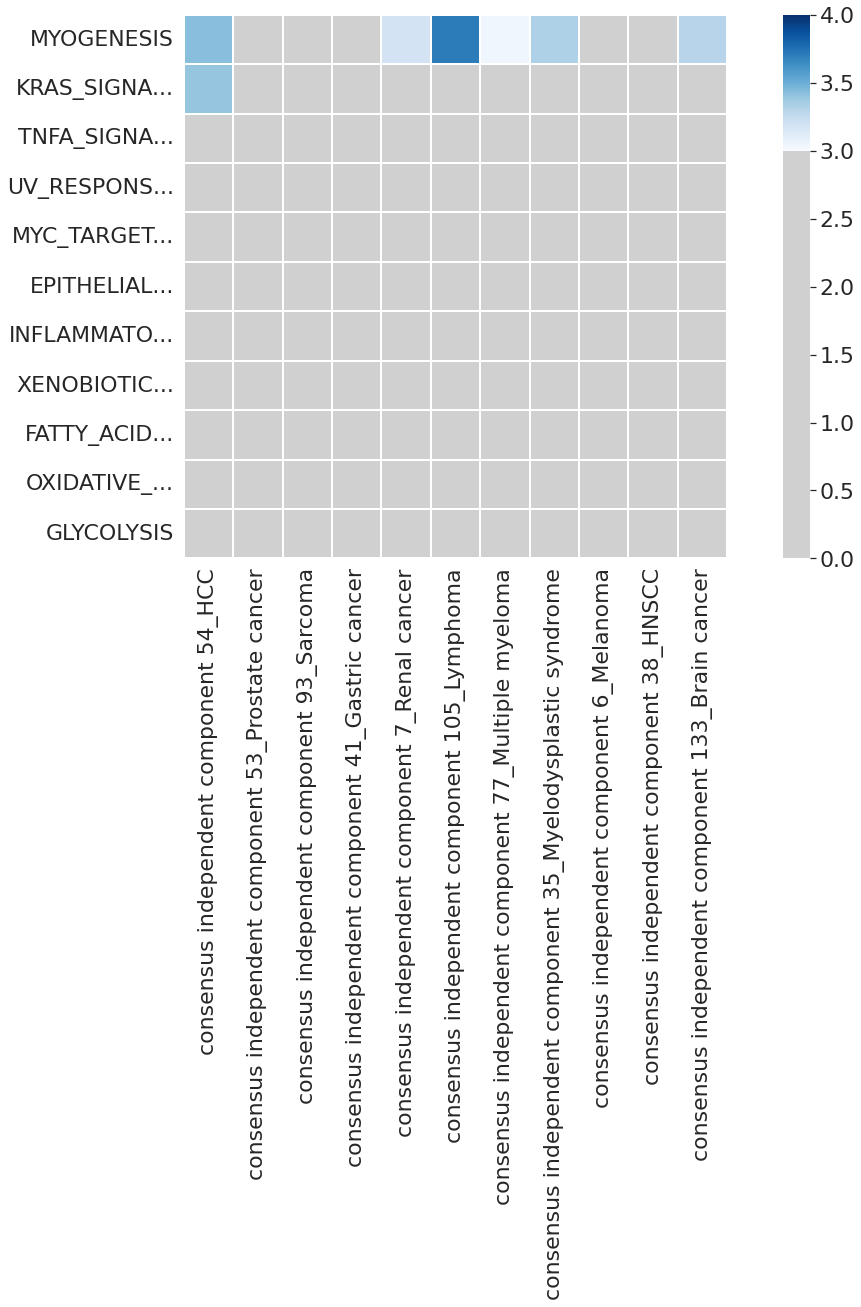

In [37]:
cutoff = 3
# Plot the 11 top enriched genesets. 
plot_df = GSEA_ALL['HALLMARK'].loc[:,clean_cluster]
plot_df['sum'] = (plot_df > 3).sum(axis=1)
plot_df = plot_df.sort_values('sum', ascending=False)
plot_df = plot_df.drop('sum', axis=1)
plot_df = plot_df.head(11)
plot_df.index = [f'{x[:10]}...' if len(x) > 10 else x for x in plot_df.index]
sns.set(font_scale=2)
plt.figure(figsize = (20,10))

color_pallet = np.array(list(Blues256)[::-1])
size = round((len(color_pallet) / 3) * 9)
greys = np.repeat('#D0D0D0', size).tolist()
greys.extend(list(color_pallet))

g = sns.heatmap(plot_df, cmap=greys, vmin=0, vmax=4, square=True, linewidths=0.1)
plt.savefig('/home/MarkF/DivideConquer/ICA/Results/Cancer_type/HALLMARK.svg', dpi=300)


### Go biological processes genesets

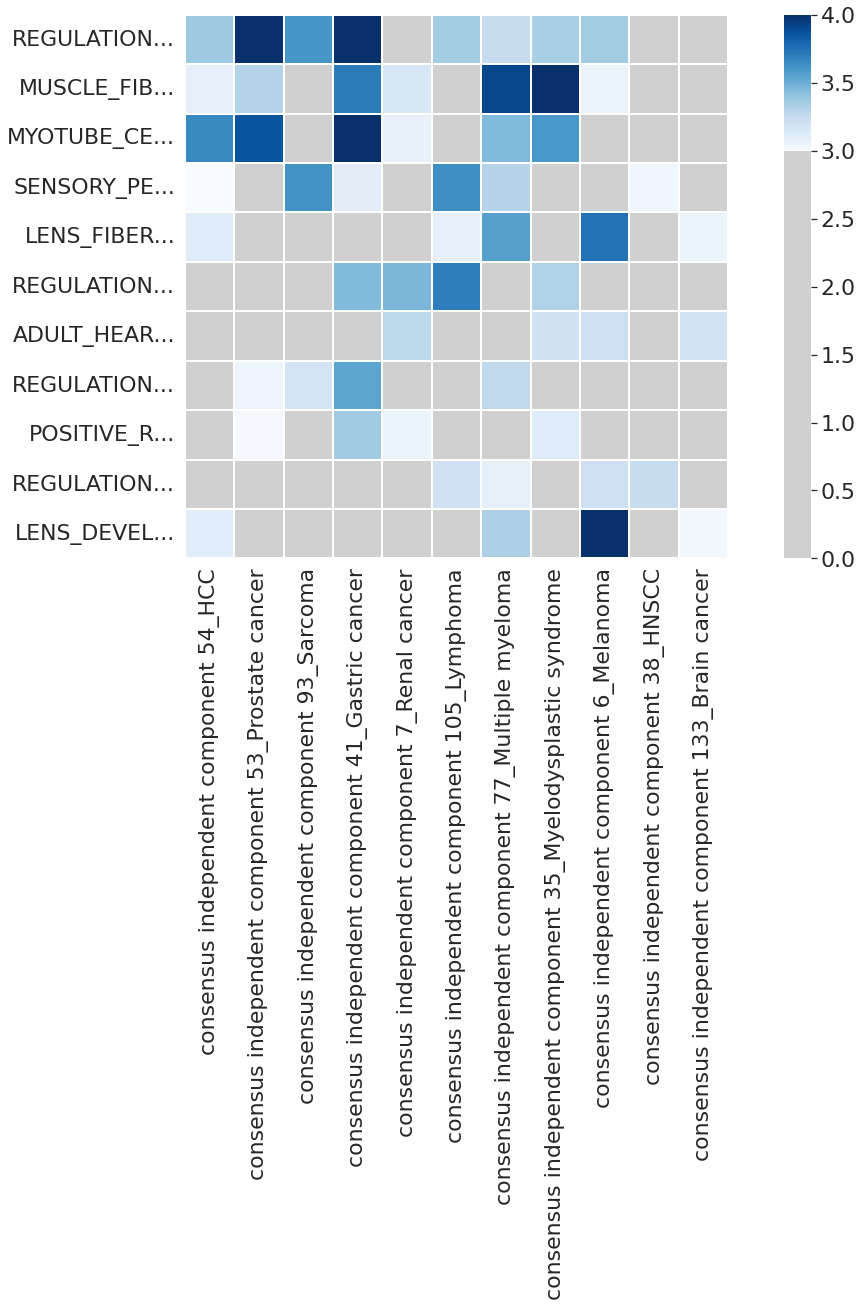

In [39]:
plot_df = GSEA_ALL['GOBP'].loc[:,clean_cluster]
plot_df['sum'] = (plot_df > 3).sum(axis=1)
plot_df = plot_df.sort_values('sum', ascending=False)
plot_df = plot_df.drop('sum', axis=1)
plot_df = plot_df.head(11)
plot_df.index = [f'{x[:10]}...' if len(x) > 10 else x for x in plot_df.index]

plt.figure(figsize = (20,10))

g = sns.heatmap(plot_df, cmap=greys, vmin=0, vmax=4, square=True, linewidths=0.1)
plt.savefig('/home/MarkF/DivideConquer/ICA/Results/Cancer_type/GOBP.svg', dpi=300)


### Reactome genesets

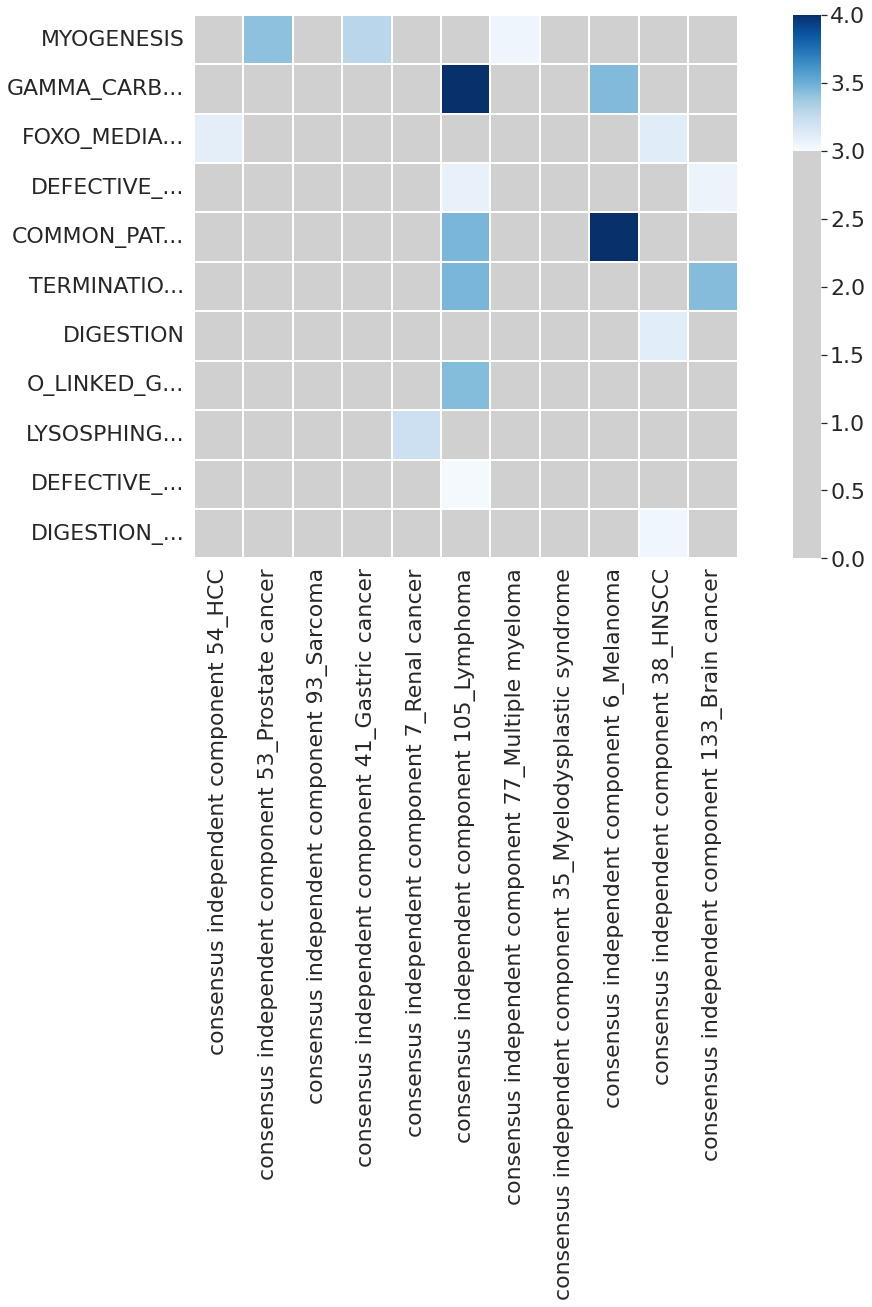

In [40]:
plot_df = GSEA_ALL['REACTOME'].loc[:,clean_cluster]
plot_df['sum'] = (plot_df > 3).sum(axis=1)
plot_df = plot_df.sort_values('sum', ascending=False)
plot_df = plot_df.drop('sum', axis=1)
plot_df = plot_df.head(11)
plot_df.index = [f'{x[:10]}...' if len(x) > 10 else x for x in plot_df.index]

plt.figure(figsize = (20,10))

g = sns.heatmap(plot_df, cmap=greys, vmin=0, vmax=4, square=True, linewidths=0.1)
plt.savefig('/home/MarkF/DivideConquer/ICA/Results/Cancer_type/REACTOME.svg', dpi=300)


No clear same funtion can be made out of this plot. Nothing is enriched in all estimated sources.

### Do they have a specific theme?

In [13]:
# Load all the different themes
dna_df = pd.read_excel('/home/MarkF/DivideConquer/Tacna_confic/GOBP_REACTOME_RELEVANT_GENESETS.xlsx',
                                    header=None)[0]
immune_df = pd.read_csv(
    '/home/MarkF/DivideConquer/Tacna_confic/gobp_immune_gene_sets_manualselection_updated.tsv', sep='\t')
immune_df = immune_df[immune_df['is_immune_process'] == True]['gene_set_name']

metabolic = pd.read_csv('/home/MarkF/DivideConquer/Tacna_confic/metabolic_gene_sets.txt', sep='\t')[
    'GO_NUCLEOBASE_METABOLIC_PROCESS']
metabolic = metabolic.str.replace('GO', 'GOBP')

In [14]:
# Look for GOBP (Because it is the biggest) if the same theme is enriched everywere
test_df = GSEA_ALL['GOBP'][b_int_components]
test_df = (test_df > 3).T
# See of any value in the row is still significant (So higher than corrected value) and only keep those
test_df = test_df[test_df.sum(axis=1) > 0]
# Loop over the significant rows and get those column names (The names of the components)
significant_components = {}
for index, row in test_df.iterrows():
    significant_components[index] = {
                        'is_immune_process': 0,
                        'is_metabolic_process': 0,
                        'is_DNA_Repair': 0,
                    }
    for geneset in list(row[row == True].index):
        geneset = f'GOBP_{geneset}'
        if geneset in dna_df.values: 
            significant_components[index]['is_DNA_Repair'] += 1
        if geneset in immune_df.values: 
            significant_components[index]['is_immune_process'] += 1
        if geneset in metabolic.values: 
            significant_components[index]['is_metabolic_process'] += 1
print(significant_components)

{'consensus independent component 54_HCC': {'is_immune_process': 1, 'is_metabolic_process': 0, 'is_DNA_Repair': 0}, 'consensus independent component 53_Prostate cancer': {'is_immune_process': 0, 'is_metabolic_process': 2, 'is_DNA_Repair': 0}, 'consensus independent component 93_Sarcoma': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 0}, 'consensus independent component 41_Gastric cancer': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 0}, 'consensus independent component 7_Renal cancer': {'is_immune_process': 2, 'is_metabolic_process': 0, 'is_DNA_Repair': 1}, 'consensus independent component 105_Lymphoma': {'is_immune_process': 0, 'is_metabolic_process': 1, 'is_DNA_Repair': 0}, 'consensus independent component 77_Multiple myeloma': {'is_immune_process': 0, 'is_metabolic_process': 1, 'is_DNA_Repair': 0}, 'consensus independent component 35_Myelodysplastic syndrome': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 0}, 'con

Also no clear anwser. There is not a specific process enriched everywere

## Inspect gene perspective
Look at a deeper level. Genes activity scores. Are the same genes highly weighted everywere?

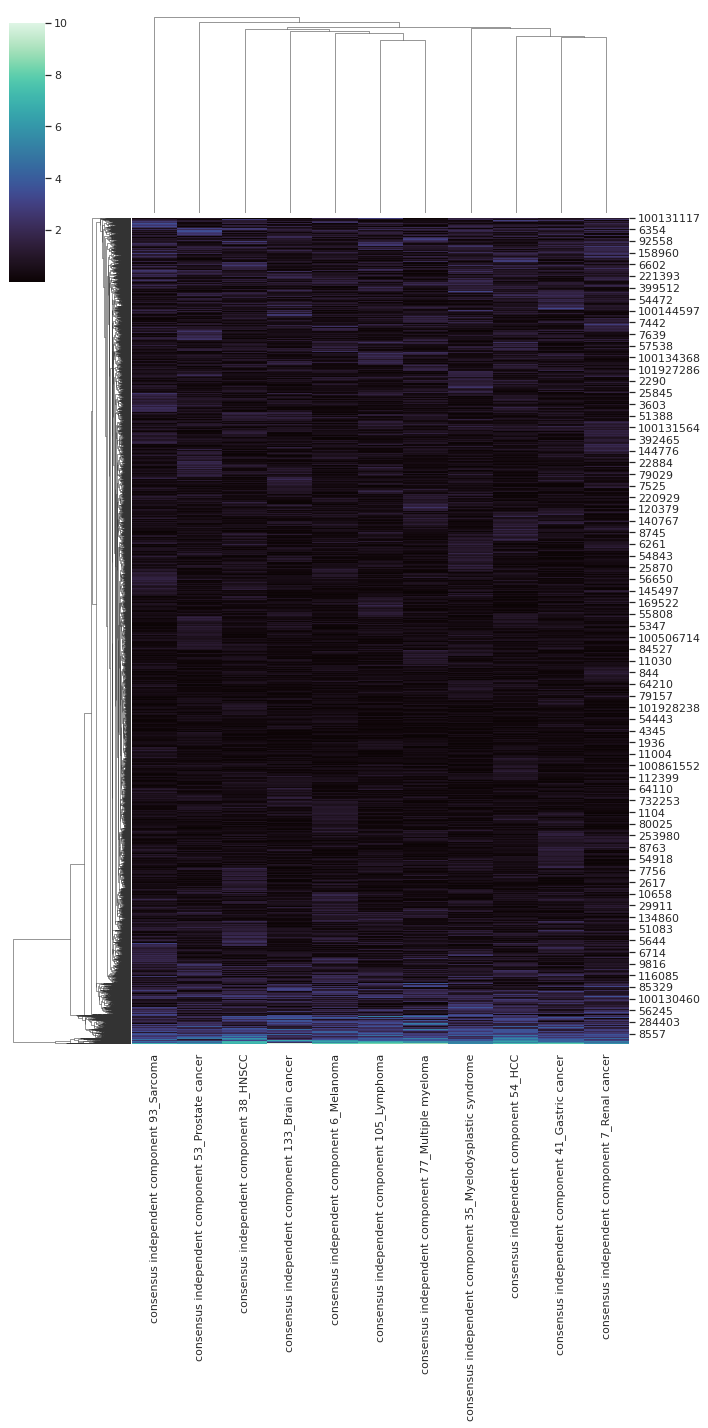

In [15]:
# Load the weights
plot_df = datasets.get_all()[b_int_components].abs()
sns.set(font_scale=1)
#plot_df = plot_df[(plot_df > 4).any(axis=1)]
sns.clustermap(plot_df, cmap='mako',
               figsize = (10,20))
plt.show()

Some same activities are shown. The bottom genes are active in all components.

### Check for CNA

In [16]:
df = pd.read_csv('/home/MarkF/DivideConquer/ICA/Results/CNA_Mutiple_Comp'
                 '/_extreme_valued_regions_all_chromosomes.txt', sep='\t')
df = df[df['extreme_value_region_status'] != 0]
df = df[df['mappings_in_region'] >= 10]

In [17]:
df

Empty DataFrame
Columns: [chrom, chromStart, chromEnd, name, extreme_value_region_status, mappings_in_region, hyperparameter]
Index: []

The components are no copy number alteration

### Guilt by association

In [18]:
# Load the ID to name File
names = pd.read_csv('/home/MarkF/DivideConquer/Tacna_confic/Genomic_Mapping_hgu133plus2_using_jetscore_30032018.txt',
           sep=None, engine='python')
names = names.groupby('SYMBOL').first().reset_index().set_index('ENTREZID')['SYMBOL']

In [19]:
# Top 100 genes for every component
plot_df = datasets.get_all()[b_int_components].abs()
plot_df = plot_df.join(names)
for name in b_int_components:
    print(name.split('_')[1])
    print(' '.join(list(plot_df.sort_values(name, ascending=False).head(100)['SYMBOL'])))
    print('_________________________________________________________________________________________')

HCC
PLEKHG5 TPD52L3 ADAMTS10 CYP11B2 CADM4 SPRED3 BBC3 FABP2 LINC00475 CELF3 FUT7 IL34 MAPRE3 FAM57B MYL10 TCF15 SCUBE1 ZNF646 PSD LTB4R2 APOL2 SSC4D TMEM151A TAOK2 SNAPC2 LOC283335 DES RBBP8NL KMT5C STAC3 MGAT5B IQCC IL17RE TRIM62 ZNF793 ZNF160 RBAKDN RPP25 PLA2G4F RIN1 CAPS TSC22D4 GPC2 MYOG TMEM63A RCOR2 CT62 IFNW1 GNAT1 BCL2 LOC101929536 ANKRD13B HAND2 FAM110D B3GNT8 DNAJC22 CTF1 DKFZP434L187 GPR162 HDAC7 ARRDC1-AS1 SETD1A SH3BP1 ACTA1 L1TD1 TUSC5 TONSL-AS1 PTP4A3 JSRP1 HS6ST3 TNFRSF13B SEMA3F APOL4 TSSK6 PHF24 PI16 LOC151174 KCNC3 IL12RB1 CEP83-AS1 FOXO4 KLK9 LOC105369921 LPIN3 LINC00482 IQSEC2 ZNF574 HMX1 C19orf68 AVP ARHGEF19 ROM1 KIFC3 C5orf38 MAP6D1 SHANK1 RCE1 WAS NAPSA KCNA7
_________________________________________________________________________________________
Prostate cancer
TPD52L3 MAPRE3 ZNF646 BCL2 PLEKHG5 SSC4D FAM57B TCF15 LINC00475 RIN1 APOL2 ADAMTS10 GPR162 BAIAP2L2 LTB4R2 HMX1 C7orf43 IL34 BRSK1 KCNC3 LOC283335 PCYT2 MLXIPL TNFRSF13B CELF3 B3GNT8 FABP2 SNAPC2 ACA

All these files were put in to the Guilt by assiciation analysis to see if they share a commen function in here

### Import the results back in

In [20]:
first_run = True
for entry in os.scandir('/home/MarkF/DivideConquer/Results/Genetica'):
    if '.svg' not in entry.path:
        df = pd.read_csv(entry.path, index_col=0)
        df = df.groupby('gene_set').mean().sort_values(by='value', ascending=False)
        df.columns = [f'Score_{entry.path.split("/")[-1]}']
        df.index = [x.replace('GO_', '') for x in df.index]
        if first_run:
            gba = df
            first_run = False
        else:
            gba = gba.join(df, how='outer')


### Plot the new active genesets

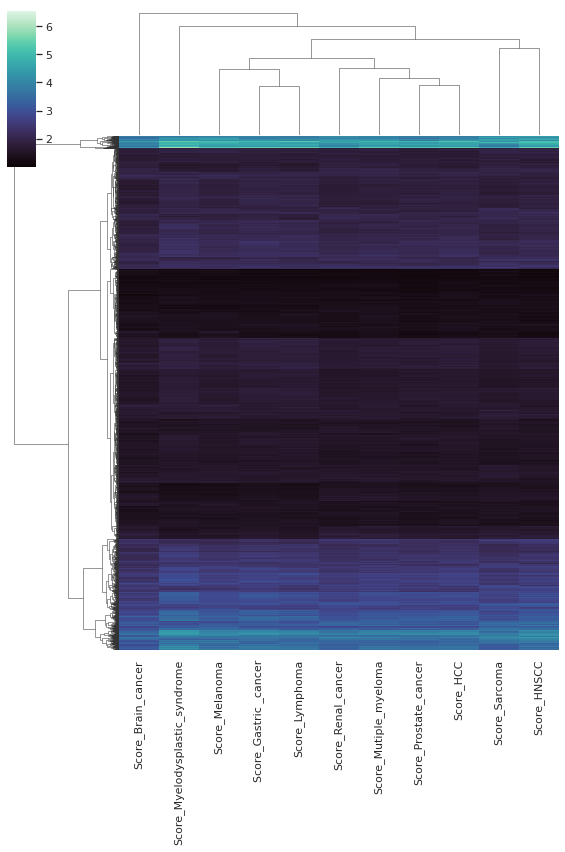

In [21]:
sns.set(font_scale=1)
g = sns.clustermap(gba, cmap='mako',
               figsize = (8,12), yticklabels=False)
plt.show()

With this analysis there can be seen that a clear cluster exist of active genesets in all components. This implies that all these estimated sources have the same funtion

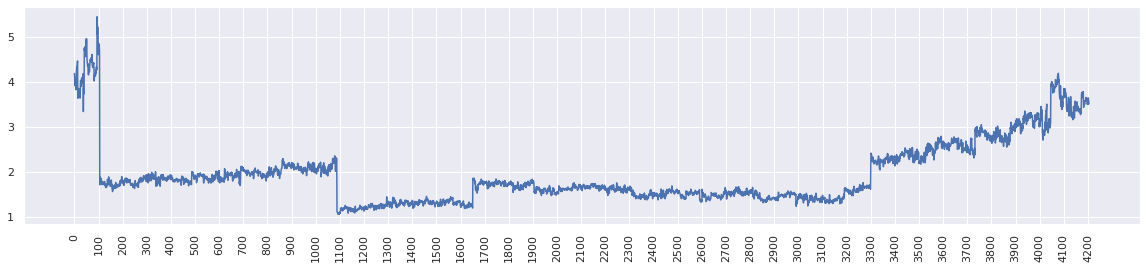

In [22]:
bot_subset_gba = gba.iloc[g.dendrogram_row.reordered_ind,g.dendrogram_col.reordered_ind]
plt.figure(figsize = (20, 4))
plt.plot(np.arange(0,len(bot_subset_gba)), bot_subset_gba['Score_Prostate_cancer'])
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(bot_subset_gba), step=100))
plt.show()

In [23]:
bot_subset_gba = gba.iloc[g.dendrogram_row.reordered_ind,g.dendrogram_col.reordered_ind].tail(905)
bot_subset_gba = bot_subset_gba.mean(axis=1)

In [24]:
top_subset_gba = gba.iloc[g.dendrogram_row.reordered_ind,g.dendrogram_col.reordered_ind].head(105)
top_subset_gba = top_subset_gba.mean(axis=1)

The weight of the top and bottem clusters in the heatmap are really quite diffrent from the other genesets. 

### Function of active genesets

In [25]:
# Get the function of the genesets with weight heiger than 5 (Top cluster)
test_df = gba
test_df = (test_df > 5).T
# See of any value in the row is still significant (So higher than corrected value) and only keep those
test_df = test_df[test_df.sum(axis=1) > 0]
# Loop over the significant rows and get those column names (The names of the components)
significant_components = {}
for index, row in test_df.iterrows():
    significant_components[index] = {
                        'is_immune_process': 0,
                        'is_metabolic_process': 0,
                        'is_DNA_Repair': 0,
                    }
    # See the active genesets
    for geneset in list(row[row == True].index):
        geneset = f'GOBP_{geneset}'
        if geneset in dna_df.values: 
            significant_components[index]['is_DNA_Repair'] = significant_components[index]['is_DNA_Repair'] + 1
        if geneset in immune_df.values: 
            significant_components[index]['is_immune_process'] += 1
        if geneset in metabolic.values: 
            significant_components[index]['is_metabolic_process'] += 1
    
print(significant_components)


{'Score_Sarcoma': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 5}, 'Score_Mutiple_myeloma': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 2}, 'Score_Prostate_cancer': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 2}, 'Score_Renal_cancer': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 1}, 'Score_HCC': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 2}, 'Score_Gastric _cancer': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 2}, 'Score_Lymphoma': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 1}, 'Score_Myelodysplastic_syndrome': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 4}, 'Score_Brain_cancer': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 1}, 'Score_Melanoma': {'is_immune_process': 0, 'is_metabolic_process': 0, 'is_DNA_Repair': 5}, 'Score_HNSCC': {'is_immune_process': 1, 'is_metabo

All components have a DNA_Repair function. This means that these components explain a pathway related to DNA_repair that was missed in the big dataset

### Make a heatmap of the top and bottem clusters to make the genesets readable

In [26]:
color_to_words =  {
    'lightblue': list(top_subset_gba.index), 
    'purple': list(bot_subset_gba.index)
}

from wordcloud import WordCloud, get_single_color_func

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


In [27]:


def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    #color = sns.color_palette("tab10")[np.random.randint(0,10)]
    color = sns.color_palette("icefire", as_cmap=False)[np.random.randint(0,6)]
    color = np.array(color) * 255
    color = color.astype(int)
    return f"rgb({color[0]}, {color[1]}, {color[2]})"

def wordmap(df, name):
    wordcloud = WordCloud(width = 2000, height = 2000,
                    background_color ='white', min_font_size=0).generate_from_frequencies(df)
    wordcloud.recolor(color_func=grey_color_func)
    # Plot
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    #plt.savefig(f'Results/Cancer_type/WordMap_{name}.svg', dpi=1200)


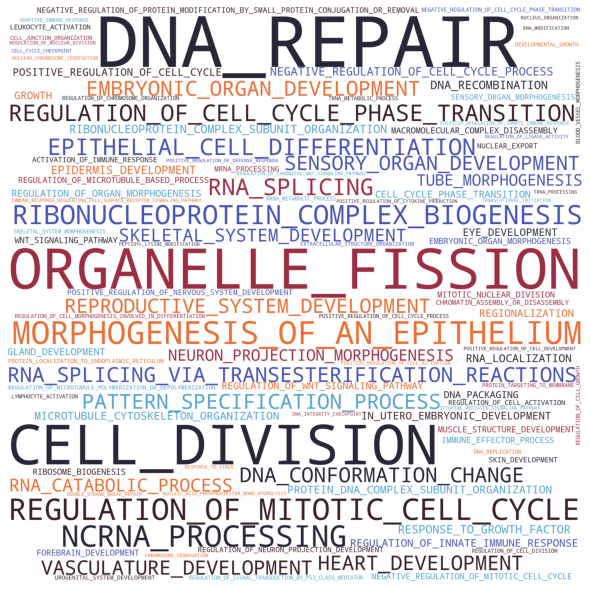

In [28]:
wordmap(top_subset_gba, 'top')

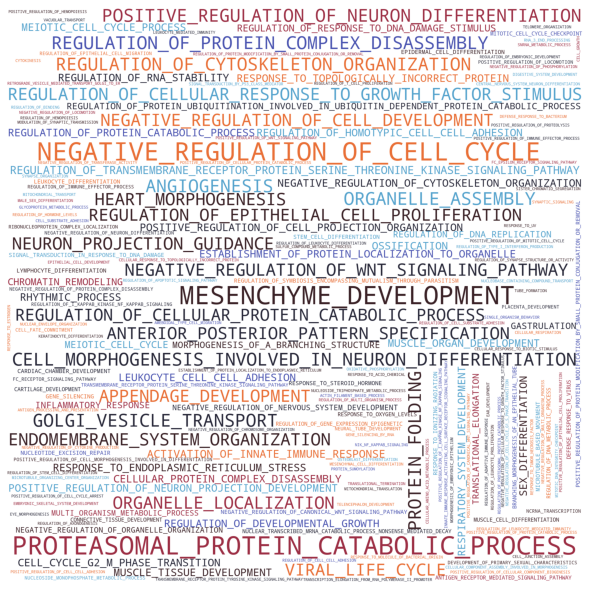

In [29]:
wordmap(bot_subset_gba, 'bot')